# mini EPSCs

**This analysis notebook is based on the method described in this paper:**<br>
O'Neill P.S., Baccino-Calace M., Rupprecht P., Lee, S., Hao, Y.A., Lin, M.Z., Friedrich R.W., Müller, M., and Delvendahl, I. (2025) A deep learning framework for automated and generalized synaptic event analysis. *eLife* 13:RP98485 ([elifesciences.org/articles/98485](https://elifesciences.org/articles/98485))

More details are available on their github page and documentation website: <br>
[https://github.com/delvendahl/miniML](https://github.com/delvendahl/miniML)  
[https://delvendahl.github.io/miniML/](https://delvendahl.github.io/miniML/)


#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
plt.rcParams.update({'figure.figsize': [14.0, 4.0]})
# %load_ext autoreload
# %autoreload 2

In [ ]:
import sys
sys.path.append('../miniML/core/')
from miniML import MiniTrace, EventDetection
from miniML_plot_functions import miniML_plots

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/HCN_channels" folder

In [3]:
data_folder = "data/miniEPSCs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/miniEPSCs


['data/miniEPSCs\\2025_06_12_0015.abf',
 'data/miniEPSCs\\2025_06_12_0016.abf',
 'data/miniEPSCs\\2025_06_12_0017.abf',
 'data/miniEPSCs\\2025_06_12_0018.abf',
 'data/miniEPSCs\\2025_06_12_0019.abf',
 'data/miniEPSCs\\2025_06_12_0020.abf',
 'data/miniEPSCs\\2025_06_12_0021.abf',
 'data/miniEPSCs\\2025_06_12_0022.abf',
 'data/miniEPSCs\\2025_06_12_0023.abf',
 'data/miniEPSCs\\25430003.abf',
 'data/miniEPSCs\\25501018.abf',
 'data/miniEPSCs\\25523016.abf',
 'data/miniEPSCs\\25523018.abf']

Choose which file you want to analyze and past the file name here:

In [ ]:
data_file = 'data/miniEPSCs\\2025_06_12_0017.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(50, 2, 105000)
sampling freq: 10000.0 Hz


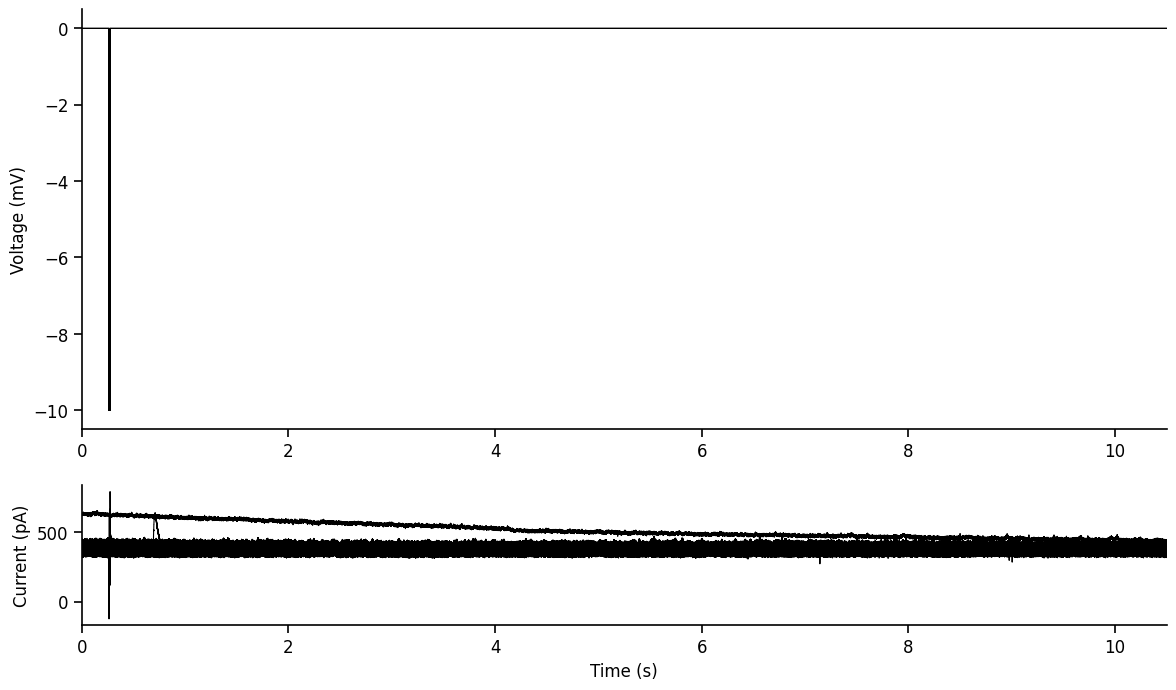

In [53]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")
current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
ax[1].set_xlabel("Time (s)")
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.9])
plt.show()

Trace callable attributes: ['data', 'sampling', 'sampling_rate', 'time_axis', 'total_time']
sampling rate: 10000.0 Hz


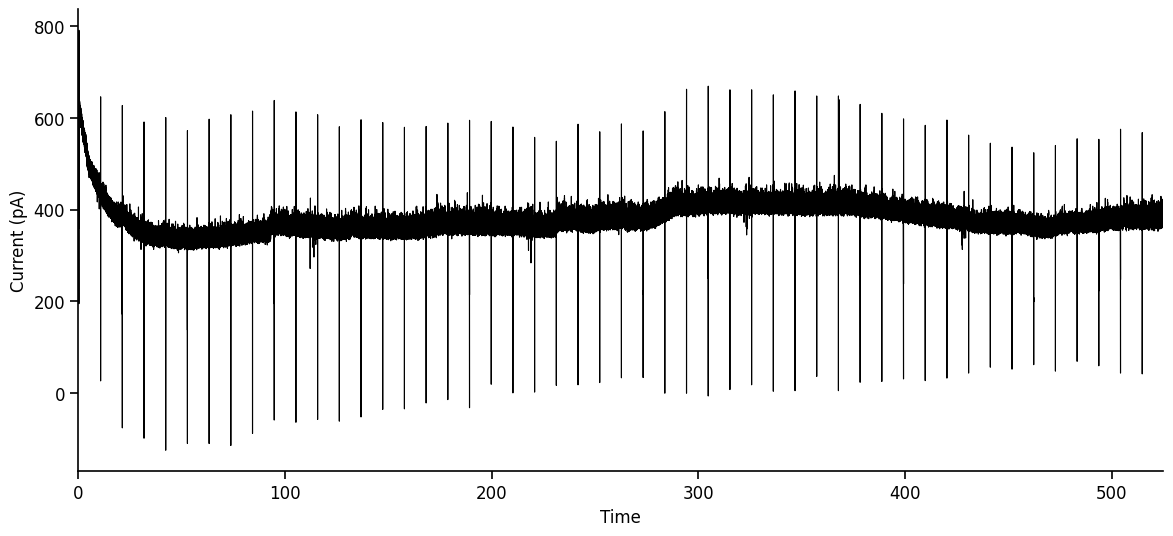

In [ ]:
current_traces = MiniTrace.from_axon_file(filename=data_file, channel=0, unit='pA')

import inspect
attributes = [name for name, value in inspect.getmembers(type(current_traces)) if isinstance(value, property)]
print(f"Trace callable attributes: {attributes}")
print(f"sampling rate: {current_traces.sampling_rate} Hz")

ax = plot_traces(current_traces.time_axis, current_traces.data)
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.9])
plt.show()

## 2. Signal processing

Let's start by filtering the signal to get a stable baseline, remove some of the 50/60 Hz line noise, and smooth away some high-frequency noise.

The goal here is to only remove the noise with minimal distortion of the data.

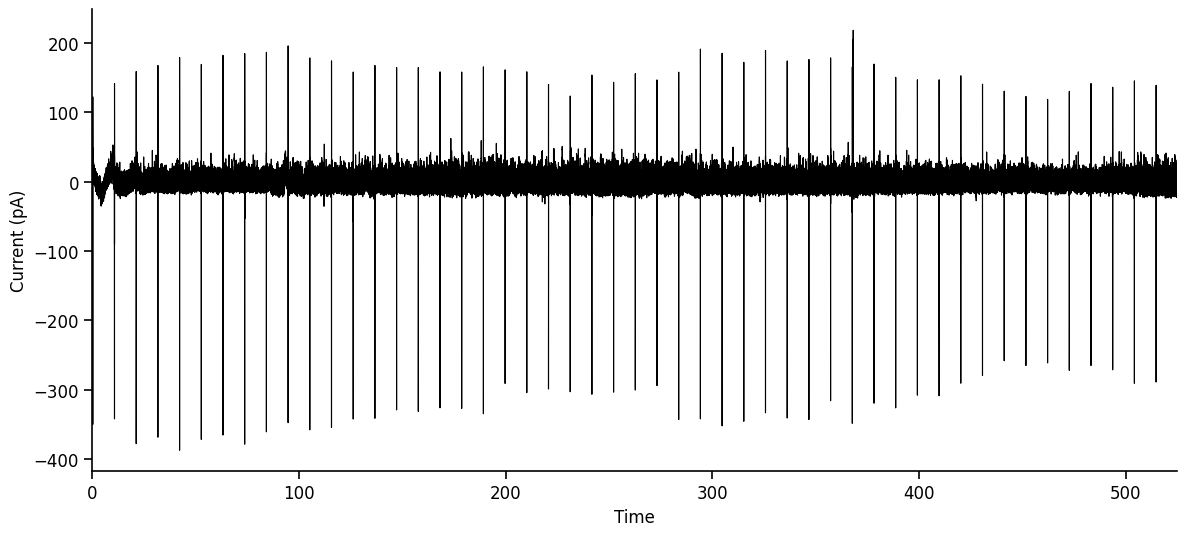

In [55]:
filtered_traces = current_traces

# Step 1: Detrend the data to remove linear or constant trends.
filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=50)

# Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
filtered_traces = filtered_traces.filter(
    line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
    width=2,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
    highpass=0.02,      # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
    lowpass=2000,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
    order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.


ax = plot_traces(filtered_traces.time_axis, filtered_traces.data)
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.9])
plt.show()

Cut out region of interest

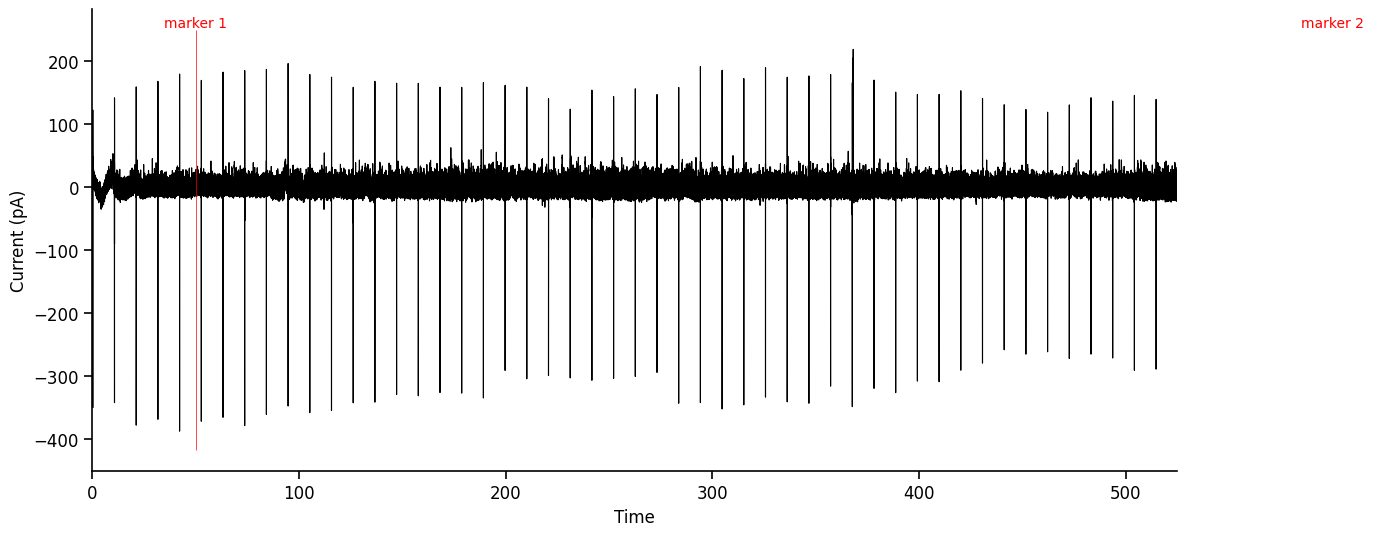

In [92]:
marker_1 = 50    # seconds
marker_2 = 600.1   # seconds
crop_trace = False

# ---------------------------------------------------------------------------------------------------------------------
current_traces = filtered_traces
ax = plot_traces(current_traces.time_axis, current_traces.data,  marker_1=marker_1, marker_2=marker_2)
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.9])
plt.show()

In [93]:
if crop_trace:
    start_idx = time_to_index(marker_1, current_traces.sampling_rate, time_unit='s')
    end_idx = time_to_index(marker_2, current_traces.sampling_rate, time_unit='s')

    current_traces_crop = MiniTrace(current_traces.data[start_idx:end_idx], sampling_interval=current_traces.sampling, y_unit=current_traces.y_unit, filename=current_traces.filename)
    ax = plot_traces(current_traces_crop.time_axis, current_traces_crop.data)
    # ax[0].set_ylim([-1000,200])
    # ax[0].set_xlim([1.1,2.9])
    plt.show()
else:
    current_traces_crop = current_traces


Run miniEPSC detection algorithm

In [94]:
win_size = 600
# direction = 'negative'
direction = 'positive'
detection_threshold = 0.3 # Lower this number if you want to detect more events, lower it if you want to reject more

# --------------------------------------------------------------------------------------------------------------------------
detection = EventDetection(data=current_traces_crop,
                        #    model_path='../miniML/models/GC_lstm_model.h5',
                           model_path='../miniML/models/transfer_learning/GC_mEPSP/lstm_transfer.h5',
                           window_size=win_size,
                           model_threshold=detection_threshold,  
                           batch_size=512,
                           event_direction=direction,
                           compile_model=True,
                           verbose=2)

detection.detect_events(eval=True,
                        peak_w=5,  # Minimum width of peaks in the prediction trace.
                        rel_prom_cutoff=0.25,   # Detection threshold for 1st derivative of trace. If there are very few overlapping events, this value can be set to 1 to find only single peaks.
                        convolve_win=20, gradient_convolve_win=40) # Don't touch this

Model loaded from ../miniML/models/transfer_learning/GC_mEPSP/lstm_transfer.h5
513/513 - 43s - 43s/epoch - 84ms/step

Event statistics:
-------------------------
    Number of events: 187
    Average score: 0.724
    Event frequency: 0.3562 Hz
    Mean amplitude: 24.1427 pA
    Median amplitude: 22.6785 pA
    Std amplitude: 9.2099 pA
    CV amplitude: 0.381
    Mean charge: 0.37689 pC
    CV charge: 0.777
    Mean 10-90 risetime: 3.819 ms
    Mean half decay time: 8.917 ms
    Mean half-width: 26.560 ms
    Tau decay: 10.790 ms
-------------------------


## Inspect the results

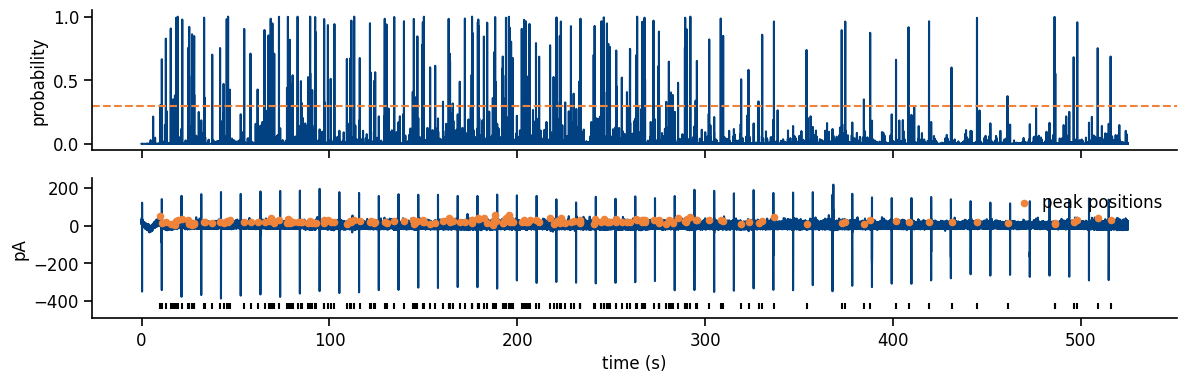

Number of events detected: 187


In [95]:
MiniPlots = miniML_plots(data=detection)
MiniPlots.plot_prediction(include_data=True, plot_filtered_prediction=True, plot_filtered_trace=False, plot_event_params=False)

print(f'Number of events detected: {detection.events.shape[0]}')

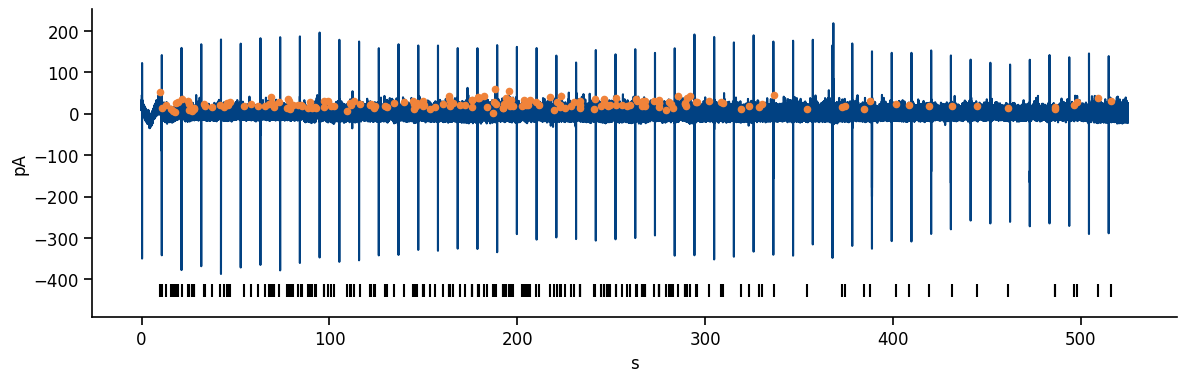

In [96]:
MiniPlots.plot_detection()

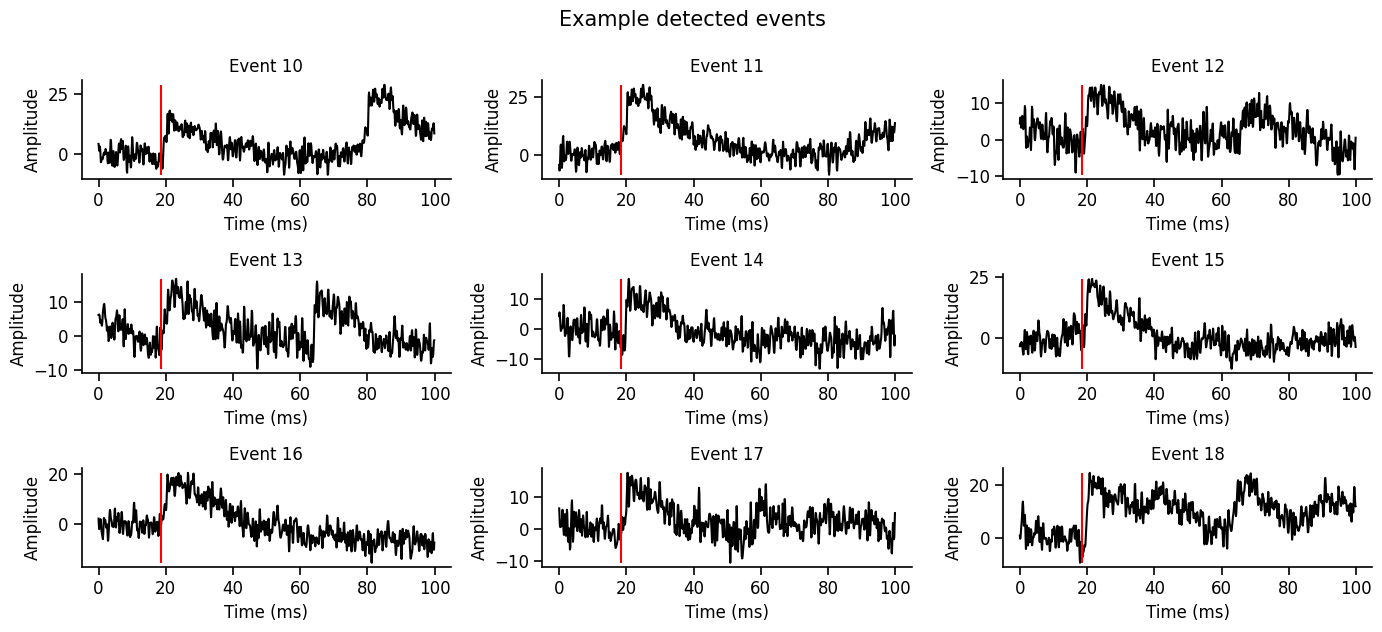

In [103]:
# Explore a few individual events
if len(detection.events)>0:
    fig, axes = plt.subplots(3,3,figsize=(14,6))
    event_nr = 10
    for i,event_idx in enumerate(range(event_nr,event_nr+9)):
        event_trace = detection.events[event_idx]
        ax = axes.flatten()[i]
        x = np.arange(1000) *1000 / current_traces.sampling_rate
        ax.plot(x, event_trace, color='k')
        ax.set_title(f'Event {event_idx}', fontsize=12)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude')
        ax.vlines(18.5,np.min(event_trace), np.max(event_trace), color='r')
    plt.tight_layout()
    plt.suptitle("Example detected events",y=1.05,fontsize=15)
    plt.show()

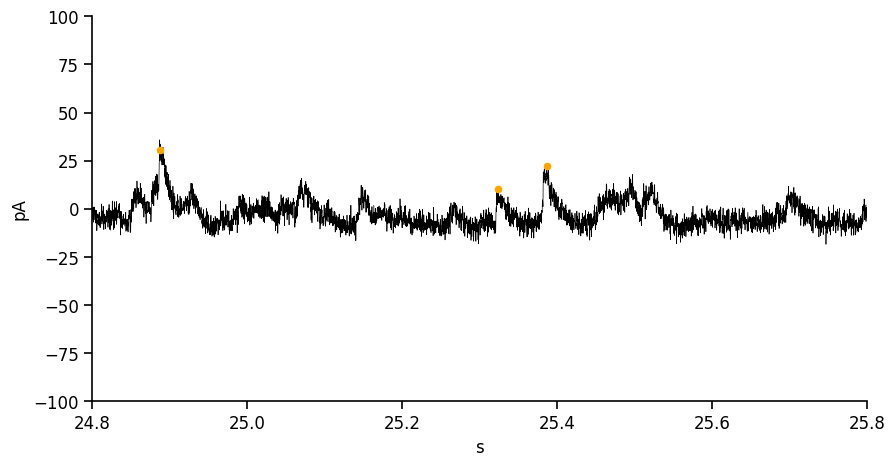

In [107]:
x_axis_range = (24.8,25.8)

y_axis_range = (-100,100)

# --------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(detection.trace.time_axis, detection.trace.data, zorder=1, c='k', linewidth=0.5)
ax.scatter(detection.event_peak_times, detection.trace.data[detection.event_peak_locations], c='orange', s=20, zorder=2)
# dat_range = np.abs(np.max(detection.trace.data) - np.min(detection.trace.data))
# dat_min = np.min(detection.trace.data)
# ax.eventplot(detection.event_peak_times, lineoffsets=dat_min - dat_range/15, linelengths=dat_range/20, color='k', lw=1.5)
ax.set_xlim(x_axis_range)
ax.set_ylim(y_axis_range)
ax.set_xlabel('s')
ax.set_ylabel(f'{detection.trace.y_unit}')
plt.show()


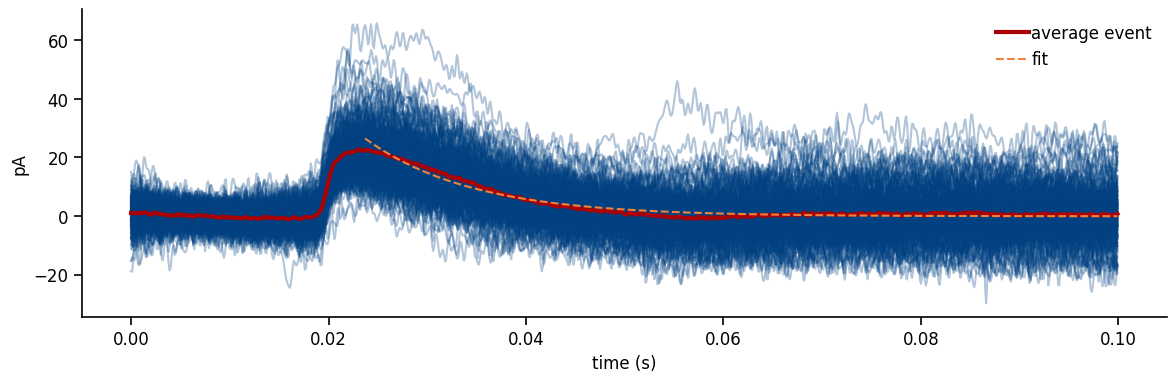


Event statistics:
-------------------------
    Number of events: 187
    Average score: 0.724
    Event frequency: 0.3562 Hz
    Mean amplitude: 24.1427 pA
    Median amplitude: 22.6785 pA
    Std amplitude: 9.2099 pA
    CV amplitude: 0.381
    Mean charge: 0.37689 pC
    CV charge: 0.777
    Mean 10-90 risetime: 3.819 ms
    Mean half decay time: 8.917 ms
    Mean half-width: 26.560 ms
    Tau decay: 10.790 ms
-------------------------


In [99]:
MiniPlots.plot_event_overlay()
detection.event_stats.print()

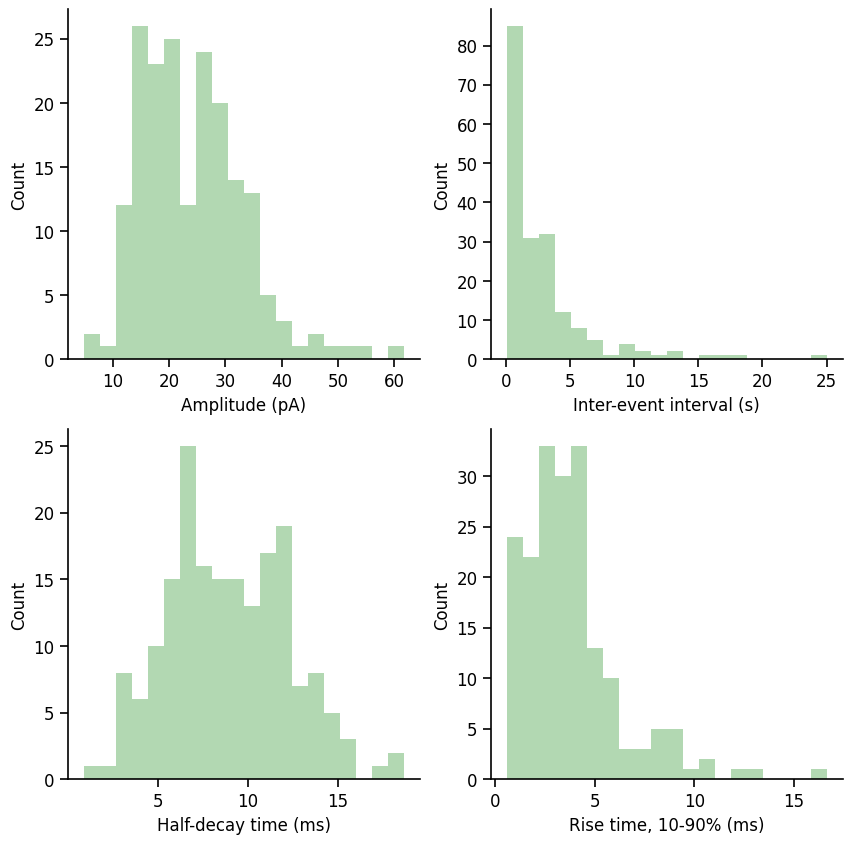

In [100]:
bin_size = 20

fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes[0,0]
amplitudes=detection.event_peak_values - detection.event_bsls
# amplitudes = detection.event_stats.amplitudes
ax.hist(amplitudes, bins=20, color='green', alpha=0.3)
ax.set_xlabel( f'Amplitude ({detection.trace.y_unit})')
ax.set_ylabel('Count')

ax = axes[0,1]
inter_event_interval = np.diff(detection.event_locations * detection.trace.sampling, prepend=0)
ax.hist(inter_event_interval, bins=bin_size, color='green', alpha=0.3)
ax.set_xlabel('Inter-event interval (s)')
ax.set_ylabel('Count')

ax = axes[1,0]
ax.hist(detection.decaytimes*1000, bins=bin_size, color='green', alpha=0.3)
ax.set_xlabel('Half-decay time (ms)')
ax.set_ylabel('Count')

ax = axes[1,1]
ax.hist(detection.risetimes*1000, bins=bin_size, color='green', alpha=0.3)
ax.set_xlabel('Rise time, 10-90% (ms)')
ax.set_ylabel('Count')
plt.show()